In [1]:
import cv2
import glob
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import shutil
import tensorflow as tf

from keras.layers.advanced_activations import LeakyReLU, PReLU
from math import cos, sin, pi
from PIL import Image
from tqdm import tqdm
from tensorflow.keras import Sequential, Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Activation, Convolution2D, MaxPooling2D, BatchNormalization, Flatten, Dense, Dropout, Conv2D, ZeroPadding2D, GlobalAveragePooling2D
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

In [2]:
os.chdir('data/1. open')

## Train, Valid Split

In [3]:
root_dir = '/home/aiffel-dj58/1.motion_keypoint/data/1. open'

In [5]:
os.makedirs(root_dir+'/train')
os.makedirs(root_dir+'/val')

In [6]:
src="train_imgs"
all_filename = os.listdir(src) #디렉토리에 있는 모든 파일을 리스트 형태로 불러옴
valid_filename = random.sample(all_filename, int(len(all_filename)*0.1))
train_filename = [x for x in all_filename if x not in valid_filename]

print(len(train_filename), len(valid_filename))

3776 419


In [7]:
train_filename = [src+'/'+name for name in train_filename]

In [8]:
valid_filename = [src+'/'+name for name in valid_filename]

In [9]:
print('Total images:' , len(all_filename))
print('Training:' , len(train_filename))
print('validation:' , len(valid_filename))

Total images: 4195
Training: 3776
validation: 419


In [10]:
for name in tqdm(train_filename):
    shutil.copy(name, 'train')

100%|██████████| 3776/3776 [00:00<00:00, 6212.98it/s]


In [11]:
for name in tqdm(valid_filename):
    shutil.copy(name, 'val')

100%|██████████| 419/419 [00:00<00:00, 5597.91it/s]


In [12]:
# train = pd.read_csv('./train.csv')
# valid = pd.read_csv('./valid.csv')

train_paths = glob.glob('./train/*.jpg')
valid_paths = glob.glob('./val/*.jpg')
test_paths = glob.glob('./test_imgs/*.jpg')
print(len(train_paths), len(valid_paths), len(test_paths))

train_paths.sort()
valid_paths.sort()
test_paths.sort()

3776 419 1600


In [13]:
train_filename = []

for t_paths in tqdm(train_paths):
    filename = t_paths.split('/')[-1]
    train_filename.append(filename)

100%|██████████| 3776/3776 [00:00<00:00, 1101063.12it/s]


In [14]:
valid_filename = []

for v_paths in tqdm(valid_paths):
    filename = v_paths.split('/')[-1]
    valid_filename.append(filename)

100%|██████████| 419/419 [00:00<00:00, 807634.82it/s]


## Augmentation

In [20]:
#Augmentation Setting
pixel_shifts = [12]
rotation_angles = [12]
inc_brightness_ratio = 1.2
dec_brightness_ratio = 0.8
noise_ratio = 0.0008

In [21]:
#좌우 반전
def left_right_flip(images, keypoints):
    flipped_keypoints = []
    flipped_images = np.flip(images, axis=1)
    for idx, sample_keypoints in enumerate(keypoints):
        if idx%2 ==0:
            flipped_keypoints.append(480.-sample_keypoints)
        else:
            flipped_keypoints.append(sample_keypoints)
            
    #left_right_keypoints_convert
    for i in range(8):
        flipped_keypoints[2+(4*i):4+(4*i)], flipped_keypoints[4+(4*i):6+(4*i)] = flipped_keypoints[4+(4*i):6+(4*i)], flipped_keypoints[2+(4*i):4+(4*i)]
    flipped_keypoints[36:38], flipped_keypoints[38:40] = flipped_keypoints[38:40], flipped_keypoints[36:38]
    flipped_keypoints[44:46], flipped_keypoints[46:48] = flipped_keypoints[46:48], flipped_keypoints[44:46]
    
    return flipped_images, flipped_keypoints

(1080, 1920, 3)


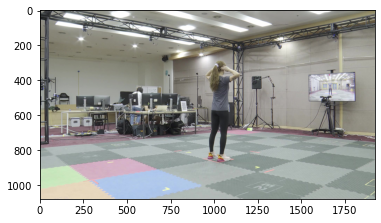

In [32]:
test_image = train_paths[0]
img = plt.imread(test_image)
plt.imshow(img)
print(img.shape)

In [68]:
img1 = tf.io.read_file(test_image)
img1 =tf.image.decode_jpeg(img1, channels=3)

In [35]:
train_df = pd.read_csv('./train_df.csv')

In [78]:
key = train_df.iloc[0, 1:49]

In [66]:
images = cv2.cvtColor(np.float32(test_image), cv2.COLOR_RGB2GRAY)

ValueError: could not convert string to float: './train/001-1-1-01-Z17_A-0000001.jpg'

In [109]:
images = img1.numpy()
shifted_images = []
shifted_keypoints = []
for shift in pixel_shifts:   
    for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
        # 이동할 matrix 생성
        M = np.float32([[1,0,shift_x],[0,1,shift_y]])
        shifted_keypoint = np.array([])
        shifted_x_list = np.array([])
        shifted_y_list = np.array([])
        # 이미지 이동
        shifted_image = cv2.warpAffine(images, M, (480,270), flags=cv2.INTER_CUBIC)#1 #cv2.warpAiffine은 축이동 메서드
        
        for idx, point in enumerate(key):
            if idx%2 == 0: 
                shifted_keypoint = np.append(shifted_keypoint, point+shift_x) #2
                shifted_x_list = np.append(shifted_x_list, point+shift_x)
            else:
                shifted_keypoint =np.append(shifted_keypoint, point+shift_y)
                shifted_y_list = np.append(shifted_y_list, point+shift_y)
                
            # 수정된 keypoint가 이미지 사이즈를 벗어나지 않으면 append
            
#         if np.all(0.0<shifted_x_list) and np.all(shifted_x_list<480) and np.all(0.0<shifted_y_list) and np.all(shifted_y_list<270):
        shifted_images.append(shifted_image.reshape(270,480,3))
        shifted_keypoints.append(shifted_keypoint)


In [105]:
for idx, point in enumerate(key):
    print(idx, point)

0 1046.3896308290402
1 344.75788121308176
2 1041.655294358602
3 329.8202250426316
4 1059.4295072365967
5 334.4842295268827
6 1020.1177961358014
7 338.8905393255204
8 1048.0
9 343.0
10 992.0
11 394.0
12 1054.0
13 400.0
14 956.0
15 368.0
16 1134.0
17 371.0
18 1003.497242322745
19 327.6400850772804
20 1078.0
21 341.0
22 999.0
23 570.0
24 1046.0
25 573.0
26 995.0
27 695.0
28 1054.0
29 698.0
30 983.0
31 820.0
32 1042.0
33 829.0
34 1019.107277064146
35 373.76622150257566
36 1013.1373595878404
37 316.31169500688765
38 1067.0
39 335.0
40 1019.4842295268828
41 455.0
42 1026.5157704731173
43 514.0547303372398
44 998.5788362716788
45 826.7180128524792
46 1063.2040674192758
47 838.827465480005


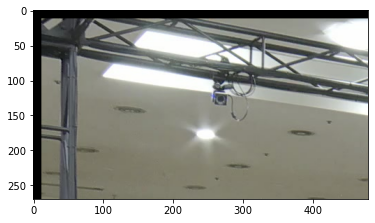

In [72]:
shifted_image = cv2.warpAffine(images, M, (480,270), flags=cv2.INTER_CUBIC) #1
plt.imshow(shifted_image)

In [96]:
shifted_keypoint #2 #24개가 point가 shifted_keypoint를 기준으로 point+shift_x 값만큼 append되었음

[1058.38963083 1053.65529436 1071.42950724 1032.11779614 1060.
 1004.         1066.          968.         1146.         1015.49724232
 1090.         1011.         1058.         1007.         1066.
  995.         1054.         1031.10727706 1025.13735959 1079.
 1031.48422953 1038.51577047 1010.57883627 1075.20406742]


In [99]:
def shift_images(images, keypoints):
    # tensor -> numpy
    images = images.numpy()
    shifted_images = []
    shifted_keypoints = []
    for shift in pixel_shifts:   
        for (shift_x,shift_y) in [(-shift,-shift),(-shift,shift),(shift,-shift),(shift,shift)]:
            # 이동할 matrix 생성
            M = np.float32([[1,0,shift_x],[0,1,shift_y]])
            shifted_keypoint = np.array([])
            shifted_x_list = np.array([])
            shifted_y_list = np.array([])
            # 이미지 이동
            shifted_image = cv2.warpAffine(images, M, (480,270), flags=cv2.INTER_CUBIC)
            # 이동한만큼 keypoint 수정
            for idx, point in enumerate(keypoints):
                if idx%2 == 0: 
                    shifted_keypoint = np.append(shifted_keypoint, point+shift_x)
                    shifted_x_list = np.append(shifted_x_list, point+shift_x)
                else: 
                    shifted_keypoint =np.append(shifted_keypoint, point+shift_y)
                    shifted_y_list = np.append(shifted_y_list, point+shift_y)
            # 수정된 keypoint가 이미지 사이즈를 벗어나지 않으면 append
            if np.all(0.0<shifted_x_list) and np.all(shifted_x_list<480) and np.all(0.0<shifted_y_list) and np.all(shifted_y_list<270):
                shifted_images.append(shifted_image.reshape(270,480,3))
                shifted_keypoints.append(shifted_keypoint)

    return shifted_images, shifted_keypoints

In [101]:
shift_image(images, key)
len(shifted_keypoints)

0

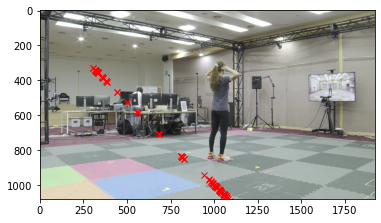

In [112]:
for j in range(0, len(shifted_keypoints), 2):
    plt.plot(shifted_keypoints[j], shifted_keypoints[j+1], 'rx')
    plt.imshow(images)